# Criando Panoramas: Live Coding Demo


## Autores

_Eduardo Bouhid (RA 299223)_

Lucas Rodrigues Pimentel (RA 252615)

Marcelo de Souza Corumba de Campos (RA 236730)

Thiago do Carmo Rodrigues Pinto (RA 237827)

Vinícius Borges Leite (RA 260716)

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.grid'] = False

In [2]:
image_folder = '../data/coffee_rotate_scene_2/'
detector_name = 'ORB'
nfeatures = 50000
lowe_ratio = 0.75
ransac_thresh = 3.0
pair = (0, 1)

Buscando imagens em: /files/Doutorado/2025s2/MO446/T1/data/coffee_rotate_scene_2
Total de imagens: 8


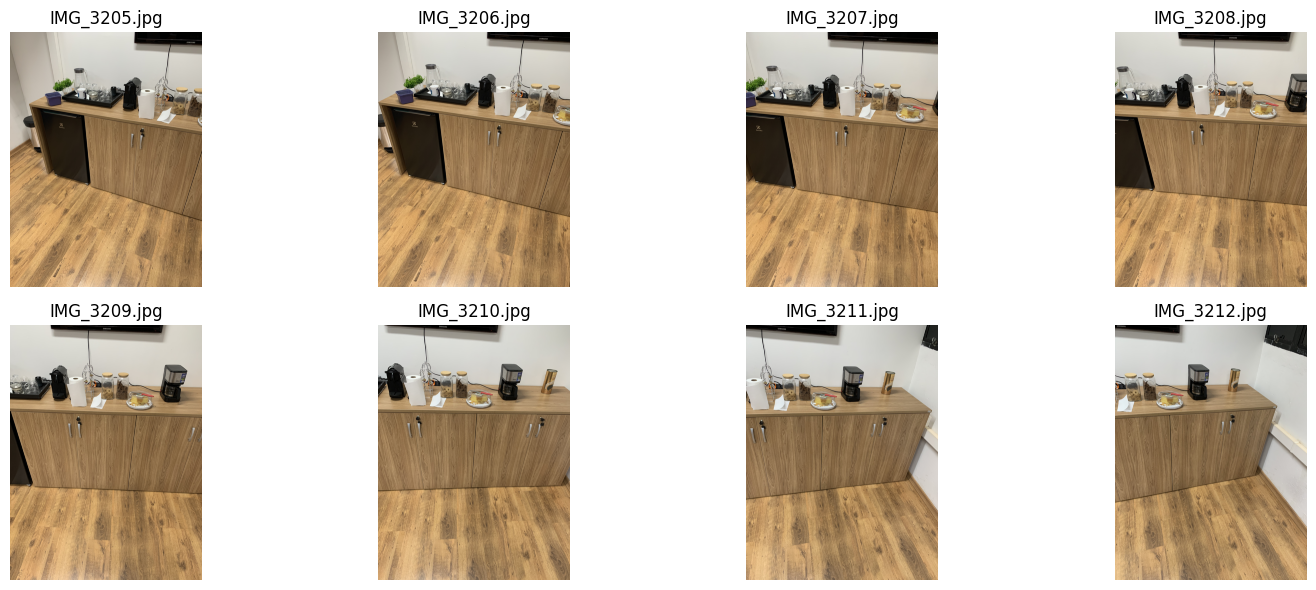

In [3]:
def imread_any(p: str):
    """Tenta carregar com OpenCV; se falhar ou for HEIC, usa Pillow."""
    img = None
    ext = os.path.splitext(p)[1].lower()
    if ext in ['.png', '.jpg', '.jpeg']:
        img = cv2.imread(p)  # BGR
    if img is None and (ext == '.heic' or HEIF_OK):
        try:
            pil = Image.open(os.path.abspath(p))
            pil = ImageOps.exif_transpose(pil)
            if pil.mode != 'RGB':
                pil = pil.convert('RGB')
            img = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
        except Exception:
            pass
    return img

def load_images(folder: str, exts=('.png', '.jpg', '.jpeg', '.heic')):
    imgs, names = [], []
    print(f'Buscando imagens em: {os.path.abspath(folder)}')
    for fname in sorted(os.listdir(folder)):
        if fname.lower().endswith(exts):
            p = os.path.join(folder, fname)
            im = imread_any(p)
            if im is not None:
                imgs.append(im)
                names.append(fname)
            else:
                print(f'Falha ao carregar: {fname}')
    print(f'Total de imagens: {len(imgs)}')
    assert len(imgs) >= 2, 'São necessárias pelo menos 2 imagens.'
    return imgs, names

images, image_names = load_images(image_folder)
# Mostrar todas as imagens da pasta
n = len(images)
cols = min(4, n)
rows = (n + cols - 1) // cols
plt.figure(figsize=(4 * cols, 3 * rows))
for idx, (im, name) in enumerate(zip(images, image_names), 1):
    plt.subplot(rows, cols, idx)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Panorama de toda a cena (todas as imagens)
Vamos encadear homografias entre imagens consecutivas e fazer o blending para gerar um panorama único.

Imagem 0 (IMG_3205.jpg): 43236 keypoints
Imagem 1 (IMG_3206.jpg): 41629 keypoints
Imagem 2 (IMG_3207.jpg): 35475 keypoints
Imagem 3 (IMG_3208.jpg): 39427 keypoints
Imagem 4 (IMG_3209.jpg): 35924 keypoints
Imagem 5 (IMG_3210.jpg): 29372 keypoints
Imagem 6 (IMG_3211.jpg): 33843 keypoints
Imagem 7 (IMG_3212.jpg): 35300 keypoints


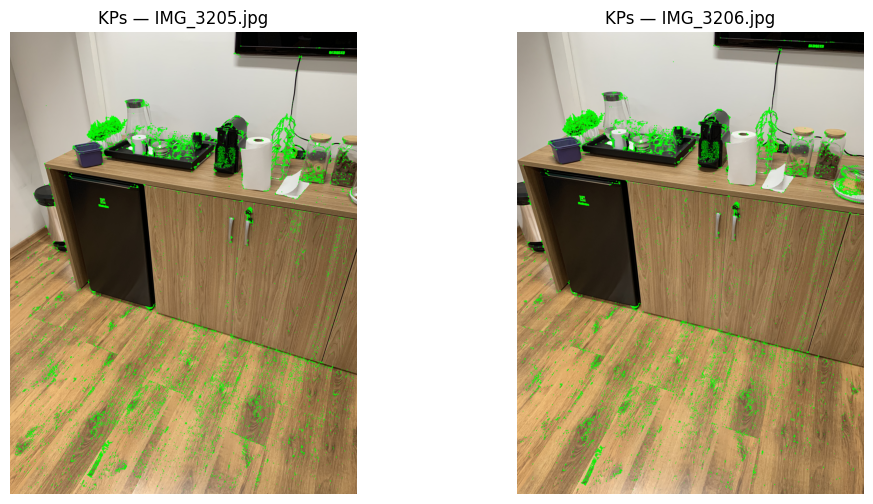

In [4]:
# Etapa 1 — Detectar características em todas as imagens
if detector_name.upper() == 'SIFT':
    detector_all = cv2.SIFT_create(nfeatures=nfeatures)
    use_flann_all = True
else:
    detector_all = cv2.ORB_create(nfeatures=nfeatures)
    use_flann_all = False

kp_all, desc_all = [], []
for i, img in enumerate(images):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, desc = detector_all.detectAndCompute(gray, None)
    kp_all.append(kp)
    desc_all.append(desc)
    print(f"Imagem {i} ({image_names[i]}): {len(kp)} keypoints")

# Visualizar keypoints para o par (0,1) como exemplo
if len(images) >= 2:
    vis0 = cv2.drawKeypoints(images[0], kp_all[0], None, color=(0,255,0))
    vis1 = cv2.drawKeypoints(images[1], kp_all[1], None, color=(0,255,0))
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(vis0, cv2.COLOR_BGR2RGB)); plt.title(f"KPs — {image_names[0]}"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(vis1, cv2.COLOR_BGR2RGB)); plt.title(f"KPs — {image_names[1]}"); plt.axis('off')
    plt.show()

### Etapa 2 — Matching entre pares consecutivos
KNN + razão de Lowe em pares (i, i+1). Visualizamos o par (0,1) como exemplo.

Par (0,1): knn=43236, bons=11074
Par (1,2): knn=41629, bons=13779
Par (2,3): knn=35475, bons=11662
Par (3,4): knn=39427, bons=13102
Par (4,5): knn=35924, bons=9879
Par (5,6): knn=29372, bons=6863
Par (6,7): knn=33843, bons=9259


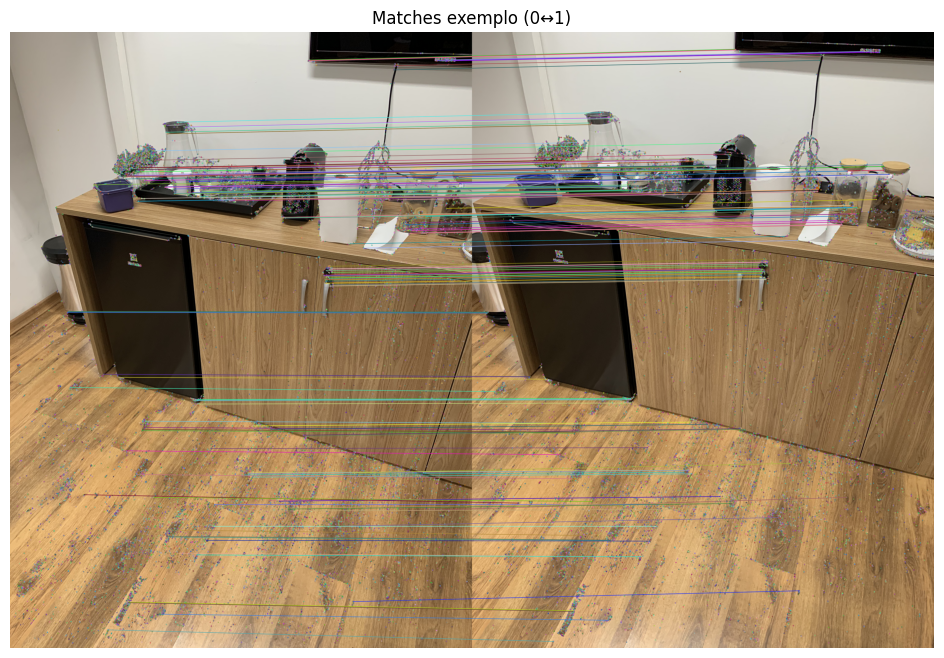

In [5]:
# Construir matcher adequado a SIFT/ORB
if use_flann_all:
    FLANN_INDEX_KDTREE = 1
    index_params_all = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params_all = dict(checks=50)
    matcher_all = cv2.FlannBasedMatcher(index_params_all, search_params_all)
else:
    matcher_all = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

pairs_good = []
for i in range(len(images) - 1):
    d1, d2 = desc_all[i], desc_all[i+1]
    if d1 is None or d2 is None:
        pairs_good.append([])
        print(f"Par ({i},{i+1}): sem descritores.")
        continue
    knn = matcher_all.knnMatch(d1, d2, k=2)
    good = [m for m, n in knn if m.distance < lowe_ratio * n.distance]
    pairs_good.append(good)
    print(f"Par ({i},{i+1}): knn={len(knn)}, bons={len(good)}")

# Visualização rápida para o par (0,1)
if len(images) >= 2 and len(pairs_good) >= 1:
    best = sorted(pairs_good[0], key=lambda x: x.distance)[:200]
    canvas = np.zeros((max(images[0].shape[0], images[1].shape[0]), images[0].shape[1] + images[1].shape[1], 3), dtype=np.uint8)
    cv2.drawMatches(images[0], kp_all[0], images[1], kp_all[1], best, canvas, matchesThickness=2)
    plt.figure(figsize=(14,8))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)); plt.title('Matches exemplo (0↔1)'); plt.axis('off')
    plt.show()

### Etapa 3 — Estimar homografias por par (RANSAC)
Calcula H(i→i+1) e visualiza inliers para o par (0,1).

In [6]:
H_forward = []
for i, good in enumerate(pairs_good):
    if len(good) < 4:
        H_forward.append(None)
        print(f"Par ({i},{i+1}): insuficientes matches.")
        continue
    ptsA = np.float32([kp_all[i][m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp_all[i+1][m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H_, mask_ = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh, maxIters=2000, confidence=0.995)
    H_forward.append(H_ if H_ is not None else None)
    if H_ is not None:
        inl = int(mask_.sum())
        print(f"Par ({i},{i+1}): H ok, inliers {inl}/{len(good)}")

# # Visualização de inliers para (0,1)
# if len(images) >= 2 and H_forward and H_forward[0] is not None:
#     good01 = pairs_good[0]
#     ptsA = np.float32([kp_all[0][m.queryIdx].pt for m in good01]).reshape(-1,1,2)
#     ptsB = np.float32([kp_all[1][m.trainIdx].pt for m in good01]).reshape(-1,1,2)
#     _, mask01 = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
#     inlier_matches01 = [m for m, keep in zip(good01, mask01.ravel().tolist()) if keep]
#     vis = np.zeros((max(images[0].shape[0], images[1].shape[0]), images[0].shape[1] + images[1].shape[1], 3), dtype=np.uint8)
#     cv2.drawMatches(images[0], kp_all[0], images[1], kp_all[1], inlier_matches01, vis, matchColor=(0,255,0), singlePointColor=(255,0,0))
#     plt.figure(figsize=(14,8))
#     plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.title('Inliers (0→1)'); plt.axis('off')
#     plt.show()

Par (0,1): H ok, inliers 4947/11074
Par (1,2): H ok, inliers 12474/13779
Par (2,3): H ok, inliers 8397/11662
Par (3,4): H ok, inliers 10707/13102
Par (4,5): H ok, inliers 7730/9879
Par (5,6): H ok, inliers 2195/6863
Par (6,7): H ok, inliers 6248/9259


### Etapa 4 — Encadear homografias até uma imagem de referência
Usamos a imagem do meio como referência; compõe H(i→ref).

In [7]:
N = len(images)
ref_idx = N // 2
I = np.eye(3, dtype=np.float64)
H_to_ref = [I.copy() for _ in range(N)]

# Encadear para esquerda do ref
for k in range(ref_idx - 1, -1, -1):
    if H_forward[k] is None:
        H_to_ref[k] = H_to_ref[k+1]
    else:
        H_to_ref[k] = H_to_ref[k+1] @ H_forward[k]
        H_to_ref[k] /= H_to_ref[k][2,2]

# Encadear para direita do ref
for k in range(ref_idx + 1, N):
    H_ref_to_k = np.eye(3, dtype=np.float64)
    ok = True
    for t in range(ref_idx, k):
        if H_forward[t] is None:
            ok = False
            break
        H_ref_to_k = H_forward[t] @ H_ref_to_k
    H_to_ref[k] = np.linalg.inv(H_ref_to_k) if ok else I.copy()
    H_to_ref[k] /= H_to_ref[k][2,2]

# Preview simples: cantos warpeados das imagens 0 e 1
if N >= 2:
    for j in [0,1]:
        h, w = images[j].shape[:2]
        corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
        warped = cv2.perspectiveTransform(corners, H_to_ref[j])
        print(f"Cantos warpeados da imagem {j} ({image_names[j]}):\n", warped.reshape(-1,2))

Cantos warpeados da imagem 0 (IMG_3205.jpg):
 [[-2207.6938   -203.82463]
 [ 1536.6921    -87.24346]
 [ 2296.5603   3510.857  ]
 [ -768.0249   4801.136  ]]
Cantos warpeados da imagem 1 (IMG_3206.jpg):
 [[-1488.9877    -57.35684]
 [ 1879.3705    -44.0961 ]
 [ 2419.2048   3603.8264 ]
 [ -601.2118   4577.451  ]]


### Etapa 5 — Calcular o canvas (tamanho do panorama)
Projeta cantos de todas as imagens para o referencial e define a área do mosaico.

Canvas: 7386x5258 | Offset: (Tx=2208, Ty=204)


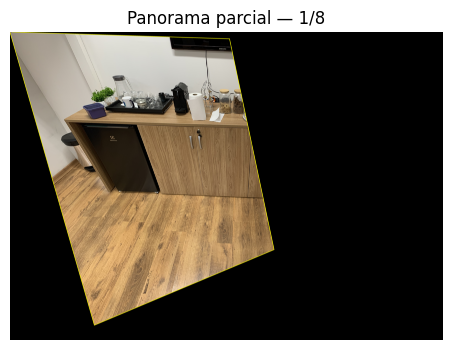

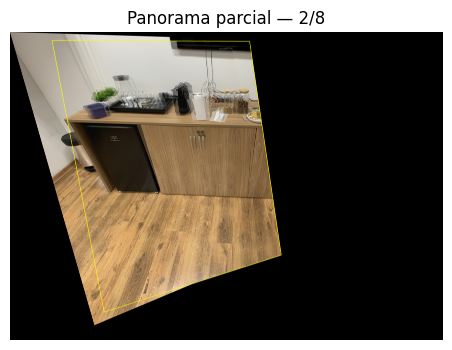

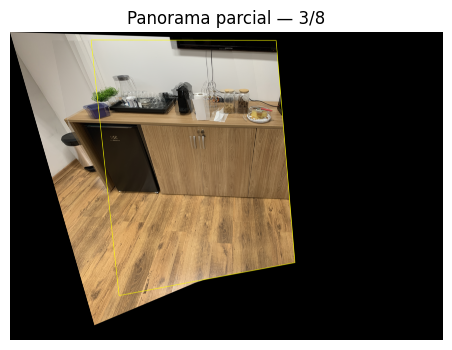

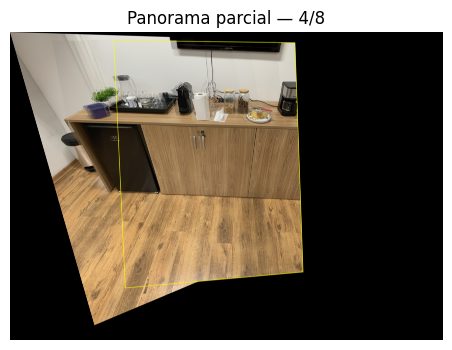

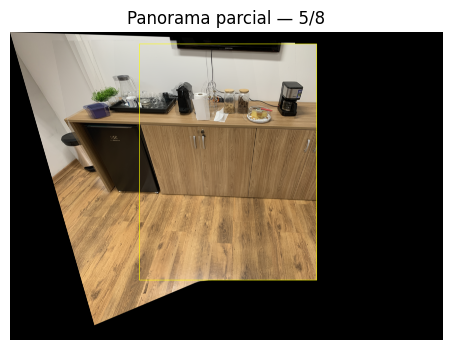

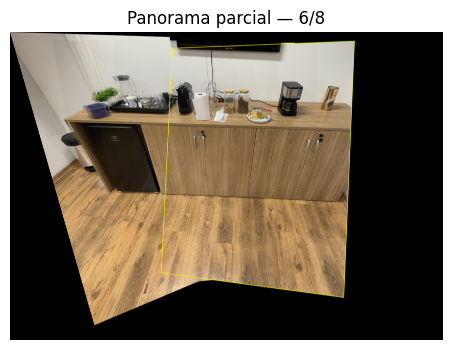

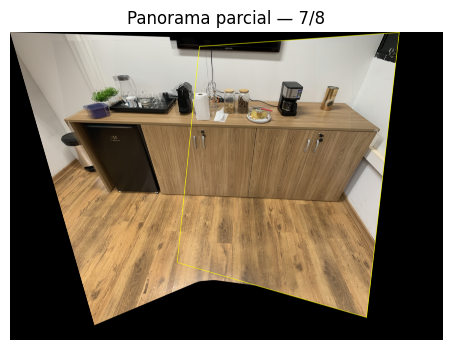

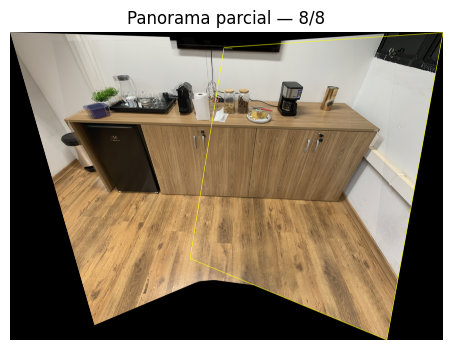

In [8]:
sigma = 11
corners_all = []
for k, img in enumerate(images):
    h, w = img.shape[:2]
    corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
    warped = cv2.perspectiveTransform(corners, H_to_ref[k])
    corners_all.append(warped)

allc = np.vstack(corners_all)
xmin, ymin = np.floor(allc.min(axis=0).ravel()).astype(int)
xmax, ymax = np.ceil(allc.max(axis=0).ravel()).astype(int)
Tx, Ty = -xmin, -ymin
T_canvas = np.array([[1,0,Tx],[0,1,Ty],[0,0,1]], dtype=np.float64)
W_canvas, H_canvas = (xmax - xmin), (ymax - ymin)
print(f"Canvas: {W_canvas}x{H_canvas} | Offset: (Tx={Tx}, Ty={Ty})")

# Construção progressiva do panorama (preview iterativo)
prog_acc = np.zeros((H_canvas, W_canvas, 3), dtype=np.float64)
prog_wsum = np.zeros((H_canvas, W_canvas, 1), dtype=np.float64)

ksize = 2 * int(3 * (sigma / 3)) + 1
ksize = max(ksize, 3)
eps = 1e-6

for k, img in enumerate(images):
    Hk = T_canvas @ H_to_ref[k]
    warped_img = cv2.warpPerspective(img, Hk, (W_canvas, H_canvas))
    base_mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
    warped_mask = cv2.warpPerspective(base_mask, Hk, (W_canvas, H_canvas))

    weight = warped_mask.astype(np.float32) / 255.0
    weight = cv2.GaussianBlur(weight, (ksize, ksize), sigmaX=sigma)
    weight *= (warped_mask > 0).astype(np.float32)
    internal = weight > 0
    weight[internal] = np.maximum(weight[internal], eps)

    prog_acc += warped_img.astype(np.float64) * weight[..., None]
    prog_wsum += weight[..., None]

    partial = (prog_acc / (prog_wsum + 1e-6)).clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(8, 4))
    plt.imshow(cv2.cvtColor(partial, cv2.COLOR_BGR2RGB))
    plt.title(f'Panorama parcial — {k+1}/{len(images)}')
    plt.axis('off')
    # Add a visual 'halo' to highlight the most recently added image
    bin_mask = (warped_mask > 0).astype(np.uint8) * 255
    edges = cv2.Canny(bin_mask, 50, 150)
    halo = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)

    alpha = 0.7
    halo_color = np.array([0, 255, 255], dtype=np.float32)  # BGR (yellow)
    partial_halo = partial.astype(np.float32)
    m = halo.astype(bool)
    partial_halo[m] = partial_halo[m] * (1 - alpha) + halo_color * alpha
    partial_halo = partial_halo.clip(0, 255).astype(np.uint8)

    ax = plt.gca()
    ax.images[-1].set_data(cv2.cvtColor(partial_halo, cv2.COLOR_BGR2RGB))
    plt.show()

### Etapa 6 — Warp + Blending (feathering)
Projeta todas as imagens no canvas e aplica feathering simples para mesclar.

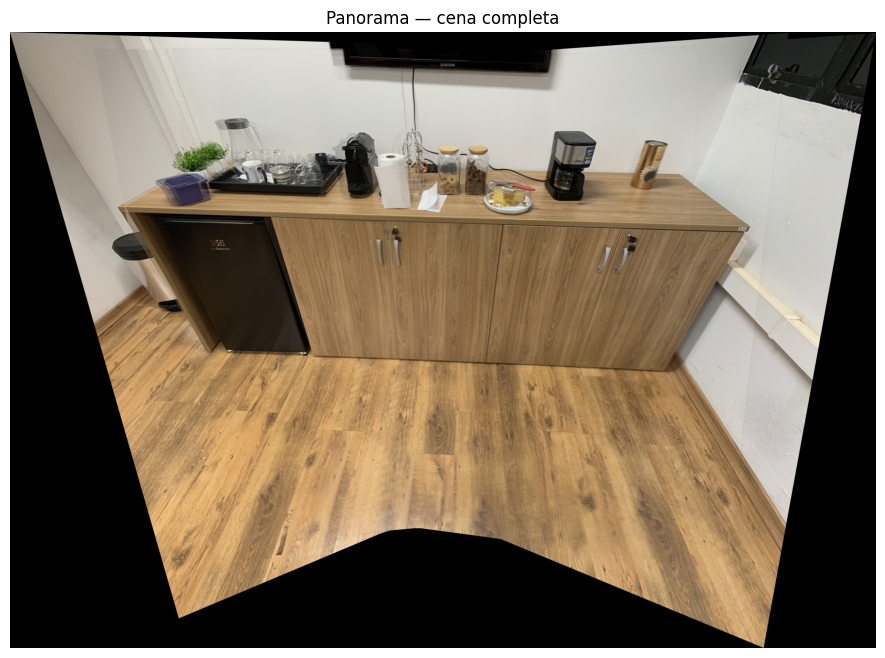

In [9]:
acc = np.zeros((H_canvas, W_canvas, 3), dtype=np.float64)
wsum = np.zeros((H_canvas, W_canvas, 1), dtype=np.float64)
sigma = 11  # feathering suave

for k, img in enumerate(images):
    Hk = T_canvas @ H_to_ref[k]
    warped = cv2.warpPerspective(img, Hk, (W_canvas, H_canvas))
    base_mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
    warped_mask = cv2.warpPerspective(base_mask, Hk, (W_canvas, H_canvas))
    weight = (warped_mask.astype(np.float32) / 255.0)

    # suaviza bordas
    ksize_val = 2 * int(3 * (sigma/3)) + 1
    ksize_val = max(ksize_val, 3)
    weight = cv2.GaussianBlur(weight, (ksize_val, ksize_val), sigmaX=sigma)
    weight *= (warped_mask > 0).astype(np.float32)

    eps = 1e-6
    internal = weight > 0
    weight[internal] = np.maximum(weight[internal], eps)

    acc += warped.astype(np.float64) * weight[..., None]
    wsum += weight[..., None]

panorama_full = (acc / (wsum + 1e-6)).clip(0,255).astype(np.uint8)
plt.figure(figsize=(16,8))
plt.imshow(cv2.cvtColor(panorama_full, cv2.COLOR_BGR2RGB)); plt.title('Panorama — cena completa'); plt.axis('off')
plt.show()

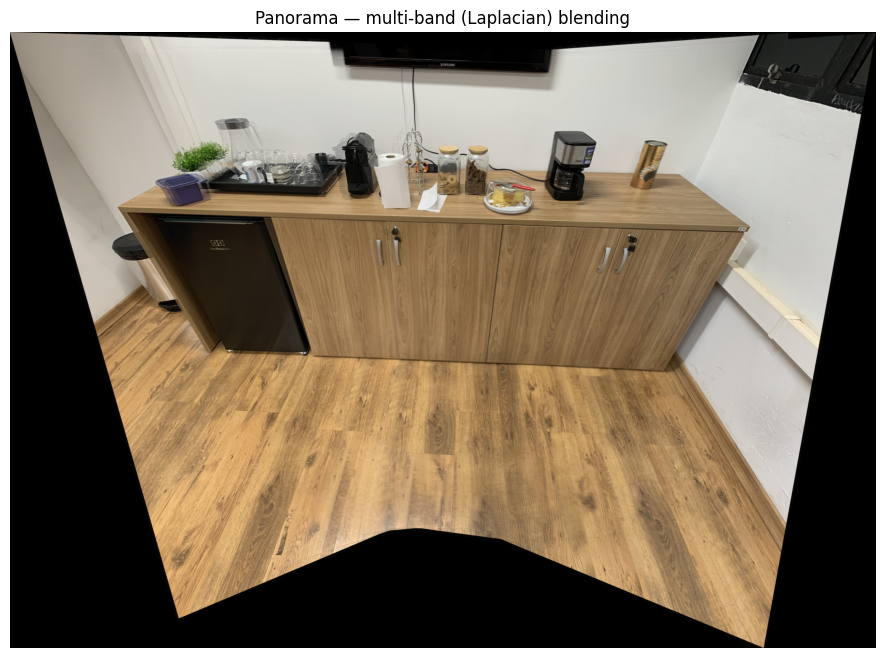

In [10]:
def _gaussian_pyramid(img, levels):
    g = [img]
    for _ in range(1, levels):
        g.append(cv2.pyrDown(g[-1]))
    return g

def _laplacian_pyramid(img, levels):
    g = _gaussian_pyramid(img, levels)
    l = []
    for i in range(levels - 1):
        up = cv2.pyrUp(g[i + 1])
        if up.shape[:2] != g[i].shape[:2]:
            up = cv2.resize(up, (g[i].shape[1], g[i].shape[0]), interpolation=cv2.INTER_LINEAR)
        l.append(g[i] - up)
    l.append(g[-1])
    return l

def _laplacian_reconstruct(lap_pyr):
    current = lap_pyr[-1]
    for i in range(len(lap_pyr) - 2, -1, -1):
        up = cv2.pyrUp(current)
        if up.shape[:2] != lap_pyr[i].shape[:2]:
            up = cv2.resize(up, (lap_pyr[i].shape[1], lap_pyr[i].shape[0]), interpolation=cv2.INTER_LINEAR)
        current = up + lap_pyr[i]
    return current

_mb_levels = 5

_zero_canvas = np.zeros((H_canvas, W_canvas, 3), dtype=np.float32)
_zero_mask = np.zeros((H_canvas, W_canvas), dtype=np.float32)
canvas_g_shapes = _gaussian_pyramid(_zero_canvas, _mb_levels)
mask_g_shapes = _gaussian_pyramid(_zero_mask, _mb_levels)

num_pyr = [np.zeros_like(level, dtype=np.float32) for level in canvas_g_shapes]
den_pyr = [np.zeros((*lvl.shape[:2], 1), dtype=np.float32) for lvl in canvas_g_shapes]

eps = 1e-8

for k, img in enumerate(images):
    Hk = T_canvas @ H_to_ref[k]
    h, w = img.shape[:2]

    warped_img = cv2.warpPerspective(img, Hk, (W_canvas, H_canvas))
    warped_img_f = warped_img.astype(np.float32)

    base_mask = np.ones((h, w), dtype=np.uint8) * 255
    warped_mask = cv2.warpPerspective(base_mask, Hk, (W_canvas, H_canvas))
    mask_bin = (warped_mask > 0).astype(np.uint8)

    if mask_bin.any():
        dt = cv2.distanceTransform(mask_bin, cv2.DIST_L2, 3)
        if dt.max() > 0:
            dt = dt / (dt.max() + eps)
        weight_base = dt.astype(np.float32)
    else:
        # No support; skip
        continue

    L_img = _laplacian_pyramid(warped_img_f, _mb_levels)           # (H,W,3) float32
    G_w   = _gaussian_pyramid(weight_base, _mb_levels)             # (H,W) float32

    for lvl in range(_mb_levels):
        w_lvl = G_w[lvl][..., None]  # (H,W,1)
        num_pyr[lvl] += L_img[lvl] * w_lvl
        den_pyr[lvl] += w_lvl

blended_lap = []
for lvl in range(_mb_levels):
    wsum = np.maximum(den_pyr[lvl], eps)
    blended = num_pyr[lvl] / wsum
    blended_lap.append(blended)

panorama_mb = _laplacian_reconstruct(blended_lap).clip(0, 255).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(panorama_mb, cv2.COLOR_BGR2RGB))
plt.title('Panorama — multi-band (Laplacian) blending')
plt.axis('off')
plt.show()